
Execution time for 1MB file:
q1 execution time: 3.6359 ms
q2 execution time: 0.9229 ms
q3 execution time: 1.3070 ms
q4 execution time: 1.8110 ms
q5 execution time: 1.1761 ms
q6 execution time: 2.9581 ms

Execution time for 10MB file:
q1 execution time: 33.4373 ms
q2 execution time: 8.3640 ms
q3 execution time: 13.0510 ms
q4 execution time: 16.1459 ms
q5 execution time: 10.5798 ms
q6 execution time: 29.9911 ms

Execution time for 100MB file:
q1 execution time: 317.8489 ms
q2 execution time: 84.7342 ms
q3 execution time: 150.7828 ms
q4 execution time: 187.8479 ms
q5 execution time: 108.0389 ms
q6 execution time: 331.0122 ms


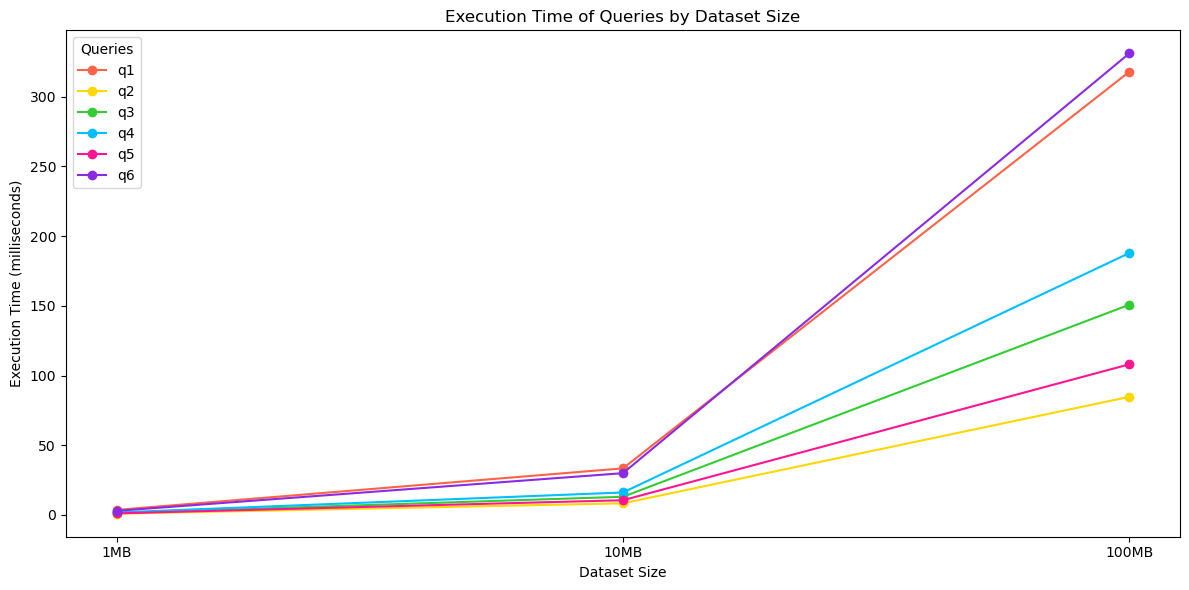

In [3]:
import sqlite3
import pandas as pd
import os
import time
import matplotlib.pyplot as plt

# Connect to SQLite database
conn = sqlite3.connect('salary_normalized_data.db')
cursor = conn.cursor()

# Creating the tables as per the schema
cursor.execute('''
    CREATE TABLE IF NOT EXISTS Person (
        PersonID INTEGER PRIMARY KEY,
        PersonName TEXT NOT NULL,
        BirthDate TEXT,
        StillWorking TEXT
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS School (
        SchoolID TEXT PRIMARY KEY,
        SchoolName TEXT NOT NULL,
        SchoolCampus TEXT NOT NULL
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS Department (
        DepartmentID TEXT PRIMARY KEY,
        DepartmentName TEXT NOT NULL
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS Job (
        JobID TEXT PRIMARY KEY,
        JobTitle TEXT NOT NULL,
        DepartmentID TEXT,
        FOREIGN KEY (DepartmentID) REFERENCES Department(DepartmentID)
    )
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS Salary (
        PersonID INTEGER,
        SchoolID TEXT,
        JobID TEXT,
        Earnings INTEGER NOT NULL,
        EarningsYear INTEGER NOT NULL,
        PRIMARY KEY (PersonID, JobID, EarningsYear),
        FOREIGN KEY (PersonID) REFERENCES Person(PersonID),
        FOREIGN KEY (SchoolID) REFERENCES School(SchoolID),
        FOREIGN KEY (JobID) REFERENCES Job(JobID)
    )
''')

base_path = '/Users/santhoshipriya/Desktop/3rd SEM/DB/Project'

input_files = {
    '1MB': os.path.join(base_path, 'salary_tracker_1MB.csv'),
    '10MB': os.path.join(base_path, 'salary_tracker_10MB.csv'),
    '100MB': os.path.join(base_path, 'salary_tracker_100MB.csv')
}

def truncate_tables(cursor):
    cursor.execute('DELETE FROM Salary')
    cursor.execute('DELETE FROM Person')
    cursor.execute('DELETE FROM School')
    cursor.execute('DELETE FROM Job')
    conn.commit()

# Load data from a single CSV file
for file_label, file_path in input_files.items():
    truncate_tables(cursor)

    df = pd.read_csv(file_path)

    for _, row in df.iterrows():
        # Inserting Data into Person table
        cursor.execute('''
            INSERT OR IGNORE INTO Person (PersonID, PersonName, BirthDate, StillWorking)
            VALUES (?, ?, ?, ?)
        ''', (row['PersonID'], row['PersonName'], row['BirthDate'], row['StillWorking']))

        # Inserting data into School table
        cursor.execute('''
            INSERT OR IGNORE INTO School (SchoolID, SchoolName, SchoolCampus)
            VALUES (?, ?, ?)
        ''', (row['SchoolID'], row['SchoolName'], row['SchoolCampus']))
                
        # Inserting data into Department table
        cursor.execute('''
            INSERT OR IGNORE INTO Department (DepartmentID, DepartmentName)
            VALUES (?, ?)
        ''', (row['DepartmentID'], row['DepartmentName']))

        # Inserting data into Job table
        cursor.execute('''
            INSERT OR IGNORE INTO Job (JobID, JobTitle, DepartmentID)
            VALUES (?, ?, ?)
        ''', (row['JobID'], row['JobTitle'], row['DepartmentID']))

        # Inserting data into Salary table
        cursor.execute('''
            INSERT OR REPLACE INTO Salary (PersonID, SchoolID, JobID, Earnings, EarningsYear)
            VALUES (?, ?, ?, ?, ?)
        ''', (row['PersonID'], row['SchoolID'], row['JobID'], row['Earnings'], row['EarningsYear']))

    conn.commit()

# Load queries from text file
queries = {}
queries_file = 'queries.txt'
with open(queries_file, 'r') as file:
    lines = file.read().splitlines()
    current_label = None
    current_query = []
    for line in lines:
        if line.startswith('#'):  
            if current_label:  
                queries[current_label] = '\n'.join(current_query)
            current_label = line[1:].strip()  # To get label without '#' from our text file
            current_query = []  
        else:
            current_query.append(line)
    if current_label: 
        queries[current_label] = '\n'.join(current_query)

# Measuring query execution times
query_results = {}

for file_label, file_path in input_files.items():
    truncate_tables(cursor)
    
    df = pd.read_csv(file_path)
    for _, row in df.iterrows():
        cursor.execute('''
            INSERT OR IGNORE INTO Person (PersonID, PersonName, BirthDate, StillWorking)
            VALUES (?, ?, ?, ?)
        ''', (row['PersonID'], row['PersonName'], row['BirthDate'], row['StillWorking']))
        cursor.execute('''
            INSERT OR IGNORE INTO School (SchoolID, SchoolName, SchoolCampus)
            VALUES (?, ?, ?)
        ''', (row['SchoolID'], row['SchoolName'], row['SchoolCampus']))
        cursor.execute('''
            INSERT OR IGNORE INTO Department (DepartmentID, DepartmentName)
            VALUES (?, ?)
        ''', (row['DepartmentID'], row['DepartmentName']))
        cursor.execute('''
            INSERT OR IGNORE INTO Job (JobID, JobTitle, DepartmentID)
            VALUES (?, ?, ?)
        ''', (row['JobID'], row['JobTitle'], row['DepartmentID']))
        cursor.execute('''
            INSERT OR REPLACE INTO Salary (PersonID, SchoolID, JobID, Earnings, EarningsYear)
            VALUES (?, ?, ?, ?, ?)
        ''', (row['PersonID'], row['SchoolID'], row['JobID'], row['Earnings'], row['EarningsYear']))
    conn.commit()

    query_results[file_label] = {}
    for description, query in queries.items():
        start_time = time.time()
        cursor.execute(query)
        result = cursor.fetchall()
        end_time = time.time()
        execution_time = (end_time - start_time) * 1000  # Execution time in milliseconds
        query_results[file_label][description] = {"Execution Time (ms)": execution_time}

# Printing execution times
for file_label, file_results in query_results.items():
    print(f"\nExecution time for {file_label} file:")
    for description, info in file_results.items():
        print(f"{description} execution time: {info['Execution Time (ms)']:.4f} ms")

# Plotting the results
query_descriptions = list(queries.keys())
num_queries = len(query_descriptions)

colors = ['#FF6347', '#FFD700', '#32CD32', '#00BFFF', '#FF1493', '#8A2BE2']
fig, ax = plt.subplots(figsize=(12, 6))

dataset_sizes = ['1MB', '10MB', '100MB']

for i, description in enumerate(query_descriptions):
    execution_times = [
        query_results[file_label][description]["Execution Time (ms)"]
        for file_label in input_files.keys()
    ]
    ax.plot(dataset_sizes, execution_times, label=f"{description}", color=colors[i], marker='o')

# Formatting the chart
ax.set_xlabel('Dataset Size')
ax.set_ylabel('Execution Time (milliseconds)')
ax.set_title('Execution Time of Queries by Dataset Size')
ax.legend(title="Queries")

# Show the plot
plt.tight_layout()
plt.show()

# Commit changes and close the connection
conn.commit()
conn.close()
